# Predicting Work Placement Status using Academic Percentages
DSCI 100 Project Proposal \
**Group 005-32**: Imanjosh Chahal, Kahsennaró-roks Deom, Romina Mahinpei

## Introduction

For most high school and post-secondary students, getting a placement at a professional workplace after graduation is of great concern. Students constantly work on obtaining qualities that employers will consider when hiring, such as volunteering, gaining experience in their fields, making connections, etc. However, students mostly work on obtaining high academic averages so that it can be recognized by employers and lead them to secure a work placement. Seeing this cycle, we chose to take on a classification project and formed the following research question: **can we predict whether an employer will hire students based on their secondary school, high school, undergrad degree, MBA degree, and employability test percentages?**

The dataset used to answer this question is the [Placement_Data_Full_Class](https://www.kaggle.com/benroshan/factors-affecting-campus-placement), collected by Jain University in Bangalore. The dataset contains 15 variables and 215 observations. Some notable variables in this dataset include secondary school percentage, high school percentage, degree percentage, MBA percentage, employability test percentage, and status of placement. Our target variable will be status of placement, indicating whether a student secured a work placement position after graduation or not. 

## Preliminary Exploratory Data Analysis
We begin the exploration by loading packages and reading the dataset from the web.

In [2]:
# load packages
library(tidyverse)
library(tidymodels)
library(repr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [4]:
# load data
data_url <- "https://raw.githubusercontent.com/DG1606/CMS-R-2020/7f00d6b5e20d99a933c582d8b544fc4d04528462/Placement_Data_Full_Class.csv"
data_original <- read_csv(data_url)
head(data_original)

Parsed with column specification:
cols(
  sl_no = col_double(),
  gender = col_character(),
  ssc_p = col_double(),
  ssc_b = col_character(),
  hsc_p = col_double(),
  hsc_b = col_character(),
  hsc_s = col_character(),
  degree_p = col_double(),
  degree_t = col_character(),
  workex = col_character(),
  etest_p = col_double(),
  specialisation = col_character(),
  mba_p = col_double(),
  status = col_character(),
  salary = col_double()
)



sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000
2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000
3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000
4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NA
5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000
6,M,55.00,Others,49.80,Others,Science,67.25,Sci&Tech,Yes,55.0,Mkt&Fin,51.58,Not Placed,NA


We note that the data is already in tidy format since it meets the following requirements:
* Each variable forms a column.
* Each observation forms a row.
* Each cells represents a single measurement.

However, since we will treat the "status" variable as our label later in the analysis, we change its column type to a factor. Then, we split the data into a testing set (25% of original data) and a training set (75% of original data).

In [8]:
# treat status as a factor
data_original <- mutate(data_original, status = as_factor(status))

# split data into testing and training sets
data_split <- initial_split(data_original, prop = 0.75, strata = status)
data_train <- training(data_split)
data_test <- testing(data_split)

We summarize the training data in the table below and display the number of observations and the means of our  predictor variables for each of the two levels of our  label.

In [9]:
# summarize training data
summary_table <- data_train %>%
    select(status, ssc_p, hsc_p, degree_p, mba_p, etest_p) %>%
    group_by(status) %>%
    summarize(count = n(), 
              mean_ssc_p = mean(ssc_p), 
              mean_hsc_p = mean(hsc_p), 
              mean_degree_p = mean(degree_p), 
              mean_mba_p = mean(mba_p), 
              mean_etest_p = mean(etest_p))
summary_table

`summarise()` ungrouping output (override with `.groups` argument)



status,count,mean_ssc_p,mean_hsc_p,mean_degree_p,mean_mba_p,mean_etest_p
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Placed,111,71.94279,70.48126,69.30568,62.84865,73.18189
Not Placed,51,57.88667,57.99373,61.37353,61.69941,70.19510


We first observe that we have more data points for the Placed students than the Not Placed students. This class imbalance will again be considered when training our model, and we may oversample our rare class in order to create a balance.

We then observe that Placed students appear to have higher average academic percentages than Not Placed students. This suggests that students can indeed be classified into two binary groups (Placed vs. Not Placed) based on their academic percentages, thus making this scenario an ideal candidate for classification. 

We further highlight that our dataset is an ideal candidate for classification by creating histograms to show the distribution of our predictors for each of the two levels of our label (Placed vs. Not Placed). We again observe that Placed students appear to have higher average academic percentages than Not Placed students. 

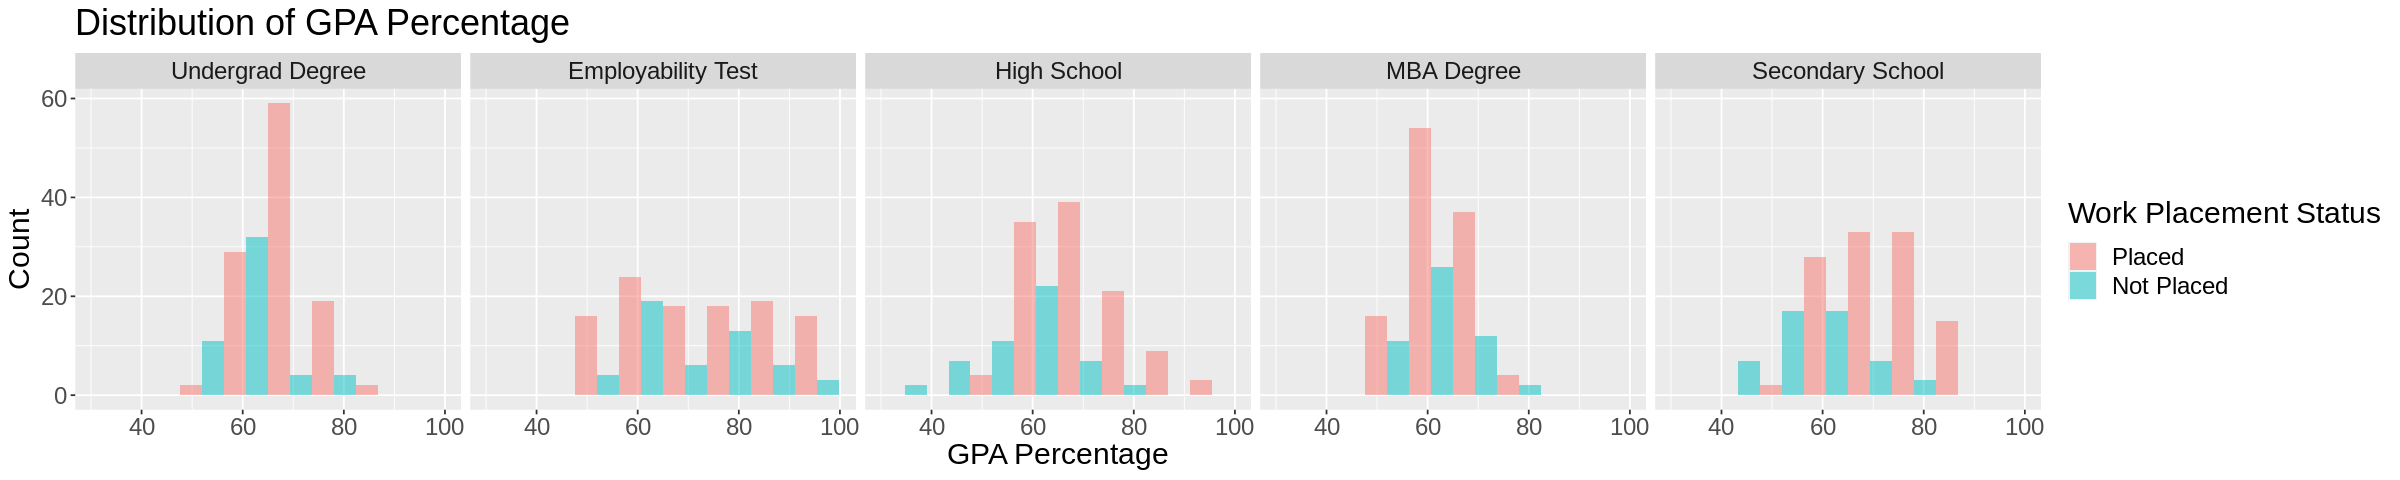

In [20]:
options(repr.plot.width = 20, repr.plot.height = 4)

# adjust data format so that facet_grid can be applied
data_plot <- data_train %>%
    select(status, ssc_p, hsc_p, degree_p, mba_p, etest_p) %>%
    pivot_longer(cols = ssc_p:etest_p,
                 names_to = "degree_type",
                 values_to = "gpa_p")

gpa_labels <- c(ssc_p = "Secondary School", 
                hsc_p = "High School", 
                degree_p = "Undergrad Degree",
                mba_p = "MBA Degree", 
                etest_p = "Employability Test")

# create histograms to show distributions of predictors
distribution_predictors <- ggplot(data_plot, aes(x = gpa_p, fill = status)) +
    geom_histogram(bins = 8, alpha = 0.5, position = "dodge") + 
    labs(x = "GPA Percentage", y = "Count", fill = "Work Placement Status") +
    facet_grid(. ~ degree_type, labeller = labeller(degree_type = gpa_labels)) + 
    ggtitle("Distribution of GPA Percentage") +
    theme(text = element_text(size = 18))
distribution_predictors

## Methods
We plan to use secondary school, high school, undergrad degree, MBA degree, and employability test percentages to predict whether a student will receive a work placement position or not. Thus, we will use ssc_p, hsc_p, degree_p, mba_p, and etest_p variables as our five predictors and treat the status column as our target variable. To verify that our predictors were relevant variables, we paired our predictors in all possible combinations (e.g. ssc_p & mba_p, hsc_p & degree_p, etc.) and created a scatterplot each time. A sample scatterplot from this process is provided below.

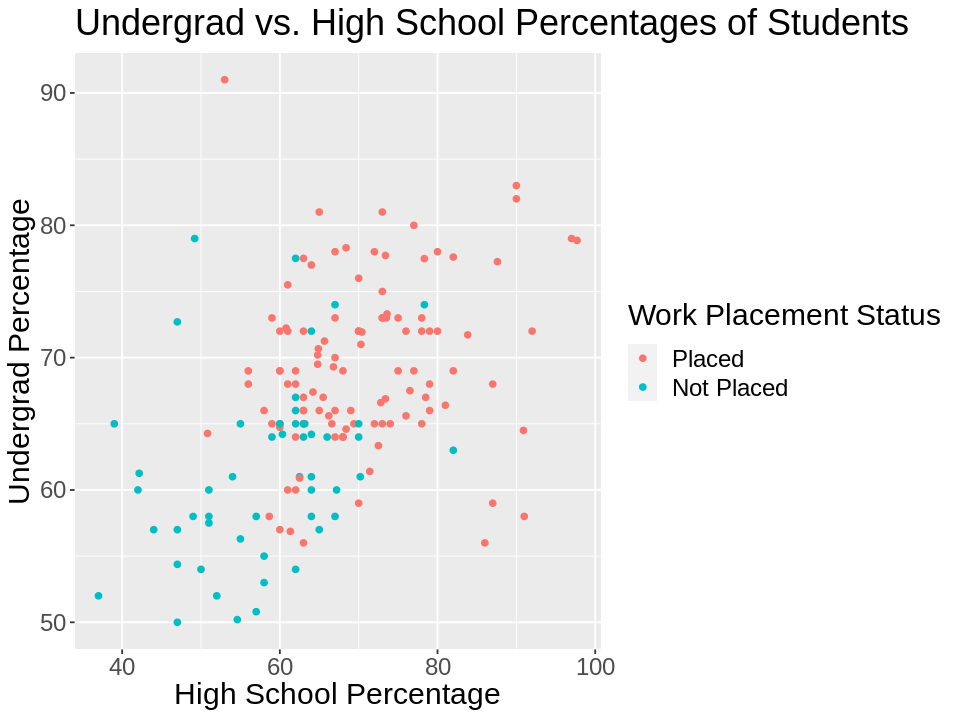

In [21]:
options(repr.plot.width = 8, repr.plot.height = 6)

scatterplot <- ggplot(data_train, aes(x = hsc_p, y = degree_p, color = status)) +
    geom_point() +
    labs(color = "Work Placement Status") +
    xlab("High School Percentage") +
    ylab("Undergrad Percentage") +
    ggtitle("Undergrad vs. High School Percentages of Students") +
    theme(text = element_text(size = 18))
scatterplot

In all scatterplots, we observed distinct clusters for the two levels of our target variable. This assured us that our chosen predictors were indeed relevant and could be used in our classification model. We plan to further verify our choice of predictors using the forward selection technique in our final project submission.  

As for training our classification model, we will use the K-nearest neighbours algorithm. We will use 75% of our available data for training and parameter tuning and the remaining 25% for testing of accuracy. We will then visualize our data using scatterplots. Similar to above, we will pair our predictors (e.g. hsc_p & degree_p, etc.) and treat one predictor from the pair as the variable on the x-axis and the other predictor as the variable on the y-axis. We will also colour our points based on their labels (Placed vs. Non-Placed) to allow the readers to make a visual guess on what a new point's label would be.

## Expected Outcomes & Significance
We expect to find whether the student will have work placement position or not, based on their secondary school, high school, undergrad degree, MBA degree, and employability test percentages.

These findings are impactful since it will be beneficial for students to have a prediction on whether they will recieve a work placement based on their academic percentages. Based on the predictions, students will know whether they should maintain or change their study habits in order to improve their academic percentages. Moreover, these findings will be especially important for students who are predicted not to receive a work placement. They can then have a clearer idea of the  percentages they should be aiming for if they are interested in getting a work placement. This can help them update their current plans and goals accordingly.

This could lead to future questions such as what could be the prediction of getting research placement, getting into Masters, getting into MastersPhD, getting into med school, etc, based on similar predictors relating to GPA.